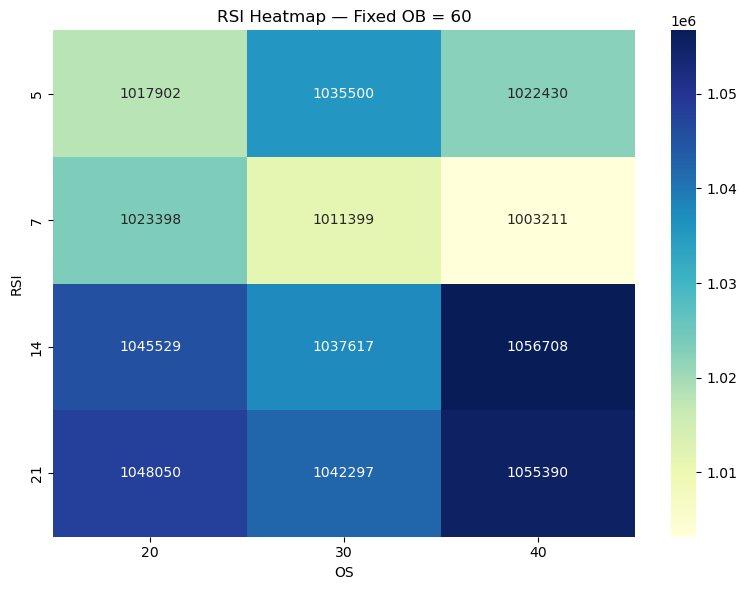

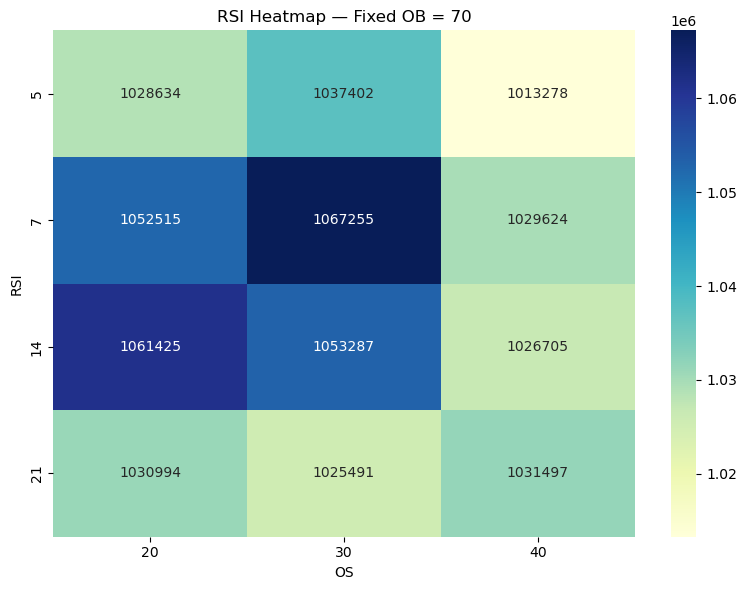

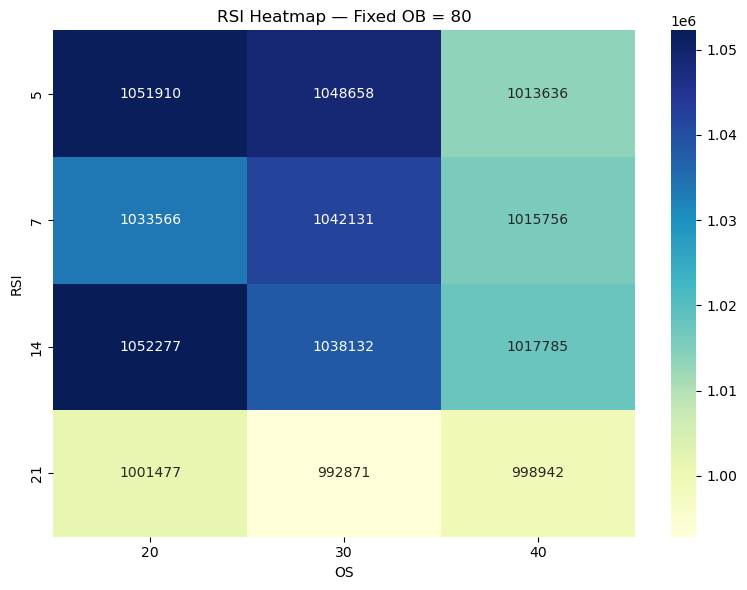

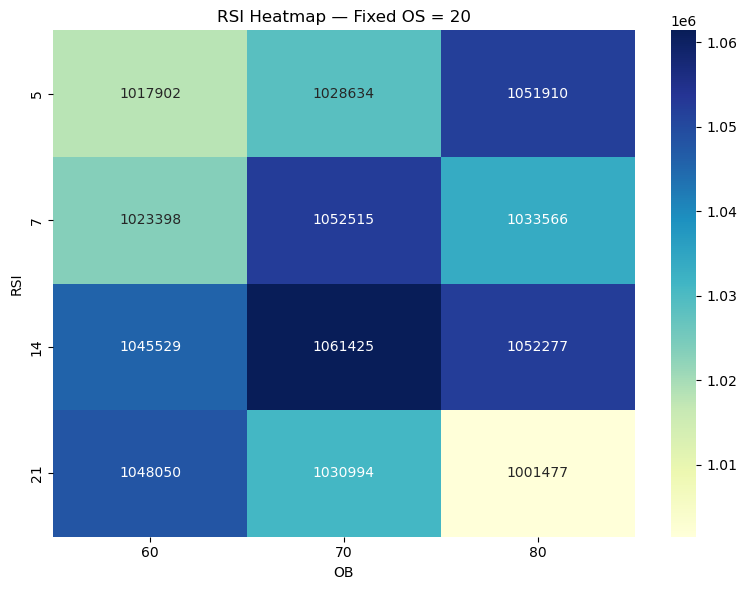

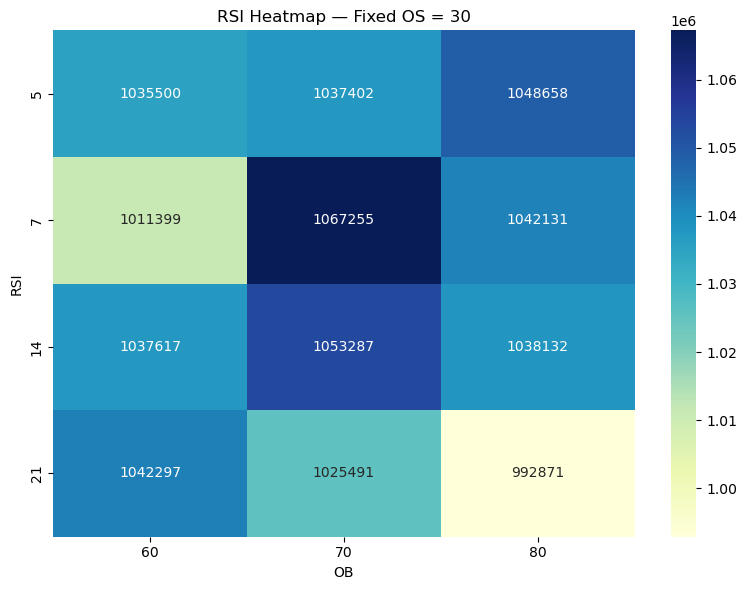

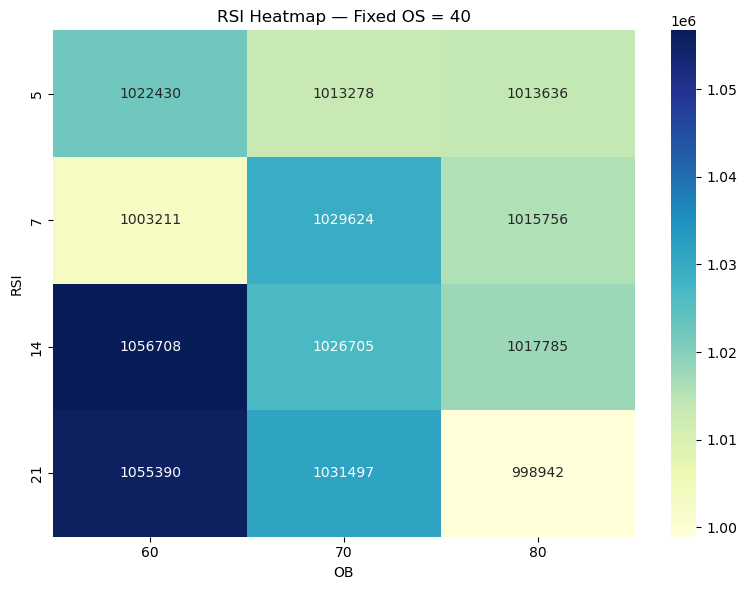

,RSI,OB,OS,Final,Trades,Win Rate (%),Swing %,Momentum %
13,7,70,30,1067255.0,2699,42.1,50.9,49.1
21,14,70,20,1061425.0,1876,43.3,31.6,68.4
20,14,60,40,1056707.8,2671,42.5,51.7,48.3
29,21,60,40,1055389.8,2660,42.7,52.3,47.7
22,14,70,30,1053286.8,2432,41.6,51.3,48.7
12,7,70,20,1052515.2,2543,42.1,44.1,55.9
24,14,80,20,1052276.8,1252,43.7,50.0,50.0
6,5,80,20,1051909.5,2510,43.2,50.4,49.6
7,5,80,30,1048657.5,2581,42.8,55.1,44.9
27,21,60,20,1048049.5,1705,43.2,12.8,87.2


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Load and Prepare Data ──────────────────────────────────────
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Constants
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY, FEE = 500, 0

# RSI parameter grids
rsi_periods = [5, 7, 14, 21]
overbought_list = [60, 70, 80]
oversold_list = [20, 30, 40]

# Volatility regime (based on returns)
returns = df['close'].pct_change()
df['VOL_S'] = returns.rolling(VOL_WIN).std()
df['VOL_L'] = returns.rolling(VOL_MED_WIN).std()
df['VOL_RATIO'] = df['VOL_S'] / df['VOL_L']

# Average True Range (ATR)
tr1 = df['high'] - df['low']
tr2 = (df['high'] - df['close'].shift()).abs()
tr3 = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df['ATR'] = tr.rolling(14).mean()

# ─── RSI Strategy Evaluation ─────────────────────────────────────
results = []

for rsi_p in rsi_periods:
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(rsi_p).mean() / loss.rolling(rsi_p).mean()
    df['RSI'] = 100 - 100 / (1 + rs)

    for ob in overbought_list:
        for os in oversold_list:
            df['Signal'] = np.select(
                [df['RSI'] < os, df['RSI'] > ob],
                [1, -1], 0
            )

            cash, pos = CASH0, 0
            stop = target = None
            equity = []
            num_trades = 0
            wins = 0
            swing_trades = 0
            momentum_trades = 0

            for i in range(1, len(df)):
                price = df['close'].iloc[i]
                atr = df['ATR'].iloc[i]
                sig = df['Signal'].iloc[i]
                vol_ratio = df['VOL_RATIO'].iloc[i]

                prev_price = df['close'].iloc[i - 1]

                # Exit logic
                if pos > 0 and (price >= target or price <= stop):
                    cash += pos * price
                    pnl = price - entry_price
                    wins += 1 if pnl > 0 else 0
                    pos = 0
                elif pos < 0 and (price <= target or price >= stop):
                    cash -= -pos * price
                    pnl = entry_price - price
                    wins += 1 if pnl > 0 else 0
                    pos = 0

                # Entry logic
                if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
                    if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                        qty = int((cash * RISK_PCT) / price)
                        qty = min(qty, MAX_QTY)
                        entry_price = price

                        if sig == 1:
                            cash -= qty * price
                            pos = qty
                            stop = price - 2.0 * atr
                            target = price + 3.0 * atr
                            swing_trades += 1
                        elif sig == -1:
                            cash += qty * price
                            pos = -qty
                            stop = price + 2.0 * atr
                            target = price - 3.0 * atr
                            momentum_trades += 1
                        num_trades += 1

                equity.append(cash if pos == 0 else cash + pos * price)

            if equity:
                results.append({
                    'RSI': rsi_p,
                    'OB': ob,
                    'OS': os,
                    'Final': equity[-1],
                    'Trades': num_trades,
                    'Wins': wins,
                    'Swing': swing_trades,
                    'Momentum': momentum_trades
                })

# ─── Results Summary ─────────────────────────────────────────────
df_res = pd.DataFrame(results)

# Calculate correct percentages
df_res['Win Rate (%)'] = (df_res['Wins'] / df_res['Trades']) * 100
df_res['Swing %'] = (df_res['Swing'] / df_res['Trades']) * 100
df_res['Momentum %'] = (df_res['Momentum'] / df_res['Trades']) * 100

# ─── Heatmaps ────────────────────────────────────────────────────
for fixed in ['OB', 'OS']:
    for val in sorted(df_res[fixed].unique()):
        pivot = df_res[df_res[fixed] == val].pivot(
            index='RSI',
            columns='OB' if fixed == 'OS' else 'OS',
            values='Final'
        )
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
        plt.title(f"RSI Heatmap — Fixed {fixed} = {val}")
        plt.xlabel('OB' if fixed == 'OS' else 'OS')
        plt.ylabel('RSI')
        plt.tight_layout()
        plt.show()

# ─── Top 10 Configurations with Extra Metrics ───────────────────
from IPython.display import display

top10 = df_res.sort_values(by='Final', ascending=False).head(10)
display(top10[['RSI', 'OB', 'OS', 'Final', 'Trades', 'Win Rate (%)', 'Swing %', 'Momentum %']].round(1))


In [68]:
import pandas as pd
import numpy as np

# Load full dataset
df_all = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Strategy parameters
RSI_P = 14
OB = 70
OS = 20
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY = 500

# Compute indicators over full dataset
returns = df_all['close'].pct_change()
df_all['VOL_S'] = returns.rolling(VOL_WIN).std()
df_all['VOL_L'] = returns.rolling(VOL_MED_WIN).std()
df_all['VOL_RATIO'] = df_all['VOL_S'] / df_all['VOL_L']

tr1 = df_all['high'] - df_all['low']
tr2 = (df_all['high'] - df_all['close'].shift()).abs()
tr3 = (df_all['low'] - df_all['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df_all['ATR'] = tr.rolling(14).mean()

delta = df_all['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
rs = gain.rolling(RSI_P).mean() / loss.rolling(RSI_P).mean()
df_all['RSI'] = 100 - 100 / (1 + rs)

df_all['Signal'] = np.select([df_all['RSI'] < OS, df_all['RSI'] > OB], [1, -1], 0)

# Periods to evaluate
periods = {
    "03feb–18feb": ("2025-02-03", "2025-02-18"),
    "31mar–15apr": ("2025-03-31", "2025-04-15"),
    "Full period": (df_all.index.min(), df_all.index.max())
}

# RSI strategy function with volatility filter
def run_rsi_strategy(df, start_date, end_date):
    df = df.copy()
    cash, pos = CASH0, 0
    stop = target = entry_price = None
    equity = []
    num_trades = wins = swing_trades = momentum_trades = 0

    for i in range(1, len(df)):
        date = df.index[i]
        price = df['close'].iloc[i]
        atr = df['ATR'].iloc[i]
        sig = df['Signal'].iloc[i]
        vol_ratio = df['VOL_RATIO'].iloc[i]

        # Exit logic
        if pos > 0 and (price >= target or price <= stop):
            cash += pos * price
            pnl = price - entry_price
            if start_date <= date <= end_date:
                wins += 1 if pnl > 0 else 0
            pos = 0
        elif pos < 0 and (price <= target or price >= stop):
            cash -= -pos * price
            pnl = entry_price - price
            if start_date <= date <= end_date:
                wins += 1 if pnl > 0 else 0
            pos = 0

        # Entry logic — includes volatility regime filter
        if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
            if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                qty = int((cash * RISK_PCT) / price)
                qty = min(qty, MAX_QTY)
                entry_price = price

                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - 2.0 * atr
                    target = price + 3.0 * atr
                    if start_date <= date <= end_date:
                        swing_trades += 1
                elif sig == -1:
                    cash += qty * price
                    pos = -qty
                    stop = price + 2.0 * atr
                    target = price - 3.0 * atr
                    if start_date <= date <= end_date:
                        momentum_trades += 1
                if start_date <= date <= end_date:
                    num_trades += 1

        if start_date <= date <= end_date:
            equity.append(cash if pos == 0 else cash + pos * price)

    # Buy & Hold
    close_prices = df.loc[start_date:end_date, 'close']
    if len(close_prices) > 0:
        buy_hold = CASH0 * (close_prices.iloc[-1] / close_prices.iloc[0])
    else:
        buy_hold = CASH0

    return {
        "Final": equity[-1] if equity else CASH0,
        "Buy & Hold": buy_hold,
        "Trades": num_trades,
        "Win Rate (%)": (wins / num_trades * 100) if num_trades > 0 else 0,
        "Swing %": (swing_trades / num_trades * 100) if num_trades > 0 else 0,
        "Momentum %": (momentum_trades / num_trades * 100) if num_trades > 0 else 0
    }

# Run and display results
results = {}
for name, (start, end) in periods.items():
    results[name] = run_rsi_strategy(df_all, pd.to_datetime(start), pd.to_datetime(end))

results_df = pd.DataFrame(results).T.round(2)
print(results_df)


                  Final  Buy & Hold  Trades  Win Rate (%)  Swing %  Momentum %
03feb–18feb   998036.25  1031911.32   340.0         39.41    26.18       73.82
31mar–15apr  1059947.00   971774.92   406.0         42.86    31.77       68.23
Full period  1061425.00   915686.93  1876.0         43.28    31.61       68.39


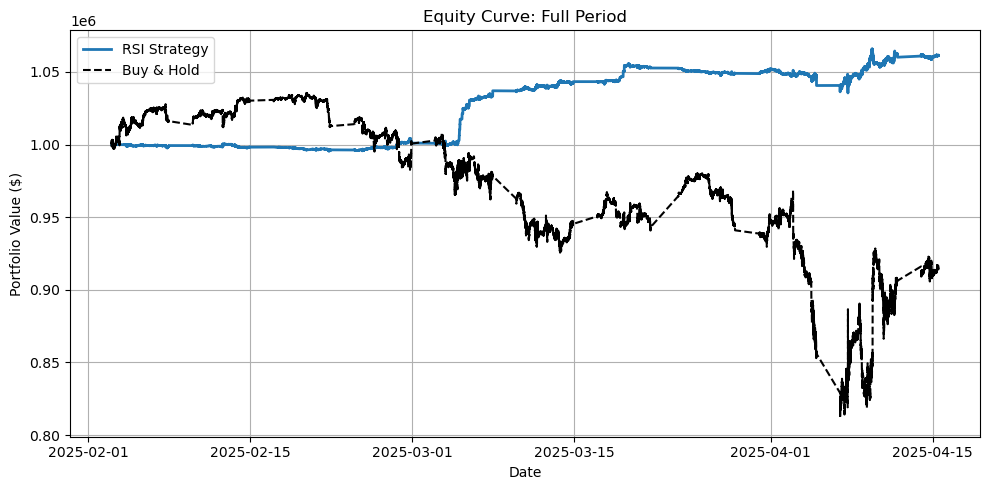

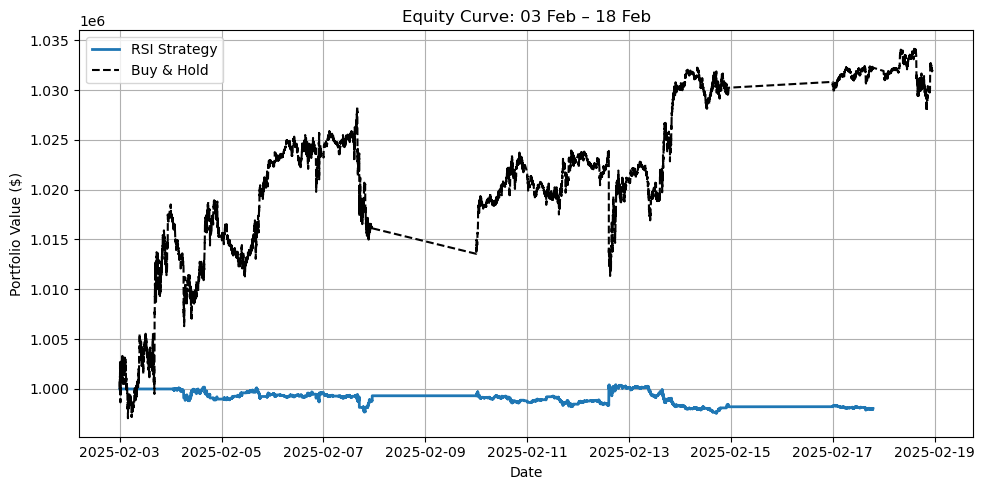

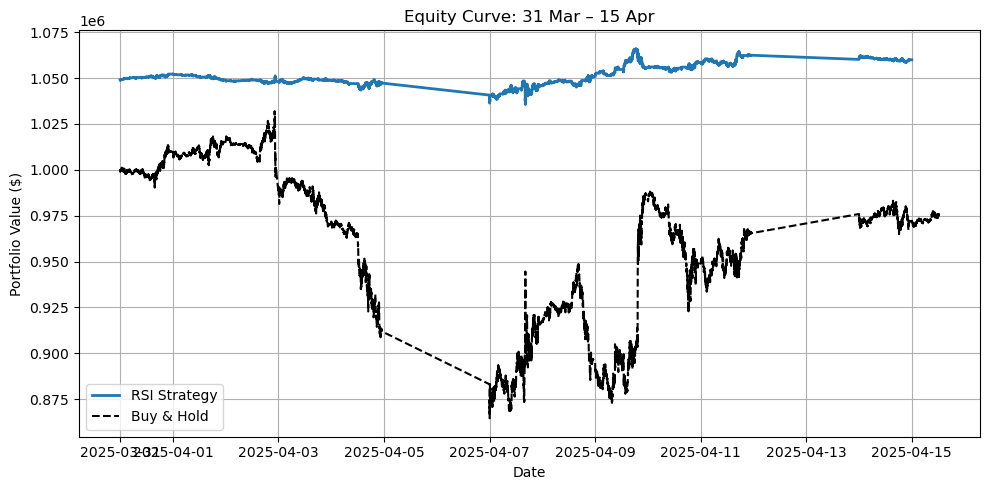

In [71]:
def run_rsi_strategy(df, start_date, end_date):
    df = df.copy()
    cash, pos = 1_000_000, 0
    stop = target = entry_price = None
    equity = []
    num_trades = wins = swing_trades = momentum_trades = 0

    for i in range(1, len(df)):
        date = df.index[i]
        price = df['close'].iloc[i]
        atr = df['ATR'].iloc[i]
        sig = df['Signal'].iloc[i]
        vol_ratio = df['VOL_RATIO'].iloc[i]

        if pos > 0 and (price >= target or price <= stop):
            cash += pos * price
            pnl = price - entry_price
            if start_date <= date <= end_date:
                wins += 1 if pnl > 0 else 0
            pos = 0
        elif pos < 0 and (price <= target or price >= stop):
            cash -= -pos * price
            pnl = entry_price - price
            if start_date <= date <= end_date:
                wins += 1 if pnl > 0 else 0
            pos = 0

        if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
            if vol_ratio > 1.1 or vol_ratio < 0.9:
                qty = int((cash * 0.20) / price)
                qty = min(qty, 500)
                entry_price = price

                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - 2.0 * atr
                    target = price + 3.0 * atr
                    if start_date <= date <= end_date:
                        swing_trades += 1
                elif sig == -1:
                    cash += qty * price
                    pos = -qty
                    stop = price + 2.0 * atr
                    target = price - 3.0 * atr
                    if start_date <= date <= end_date:
                        momentum_trades += 1
                if start_date <= date <= end_date:
                    num_trades += 1

        if start_date <= date <= end_date:
            equity.append(cash if pos == 0 else cash + pos * price)

    close_prices = df.loc[start_date:end_date, 'close']
    buy_hold = 1_000_000 * (close_prices.iloc[-1] / close_prices.iloc[0]) if len(close_prices) > 0 else 1_000_000

    return {
        "Final": equity[-1] if equity else 1_000_000,
        "Buy & Hold": buy_hold,
        "Trades": num_trades,
        "Win Rate (%)": (wins / num_trades * 100) if num_trades > 0 else 0,
        "Swing %": (swing_trades / num_trades * 100) if num_trades > 0 else 0,
        "Momentum %": (momentum_trades / num_trades * 100) if num_trades > 0 else 0,
        "Equity Curve": equity
    }

results = {}
equity_curves = {}

for name, (start, end) in periods.items():
    out = run_rsi_strategy(df_all, pd.to_datetime(start), pd.to_datetime(end))
    results[name] = {k: v for k, v in out.items() if k != "Equity Curve"}
    equity_curves[name] = out["Equity Curve"]


import matplotlib.pyplot as plt

def plot_equity_curves(df_all, equity_rsi, start, end, title):
    df_period = df_all.loc[start:end]
    bh_start = df_period['close'].iloc[0]
    bh_equity = df_period['close'] / bh_start * 1_000_000

    plt.figure(figsize=(10, 5))
    plt.plot(df_period.index[:len(equity_rsi)], equity_rsi, label="RSI Strategy", linewidth=2)
    plt.plot(df_period.index, bh_equity, label="Buy & Hold", linestyle="--", color="black")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_equity_curves(df_all, equity_curves["Full period"], "2025-02-03", "2025-04-15", "Equity Curve: Full Period")
plot_equity_curves(df_all, equity_curves["03feb–18feb"], "2025-02-03", "2025-02-18", "Equity Curve: 03 Feb – 18 Feb")
plot_equity_curves(df_all, equity_curves["31mar–15apr"], "2025-03-31", "2025-04-15", "Equity Curve: 31 Mar – 15 Apr")


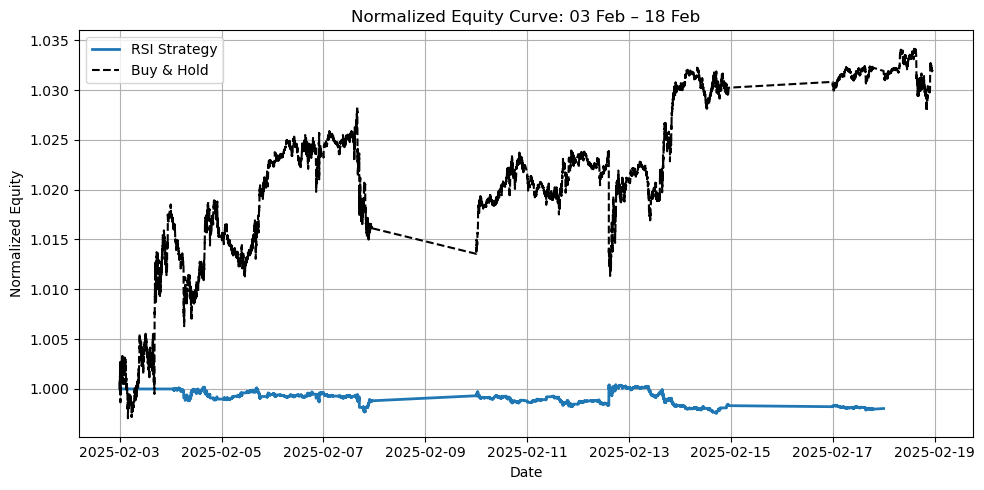

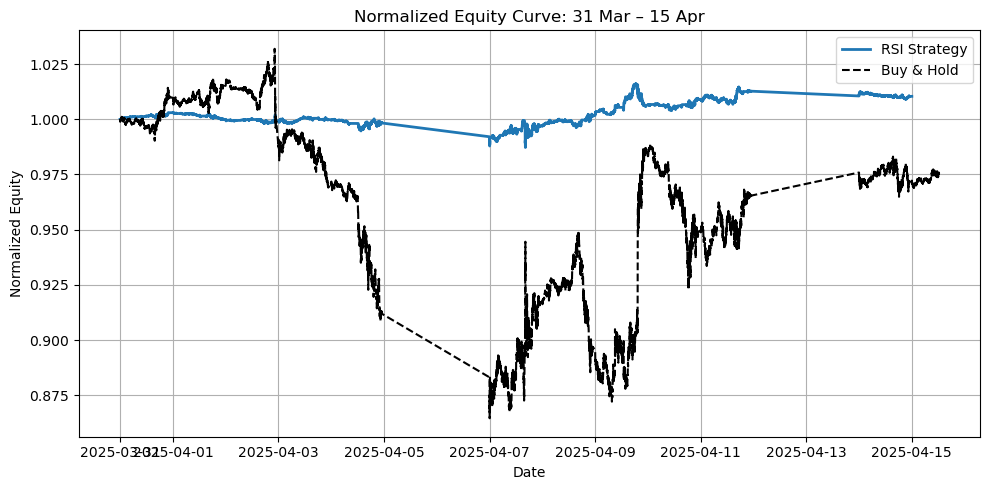

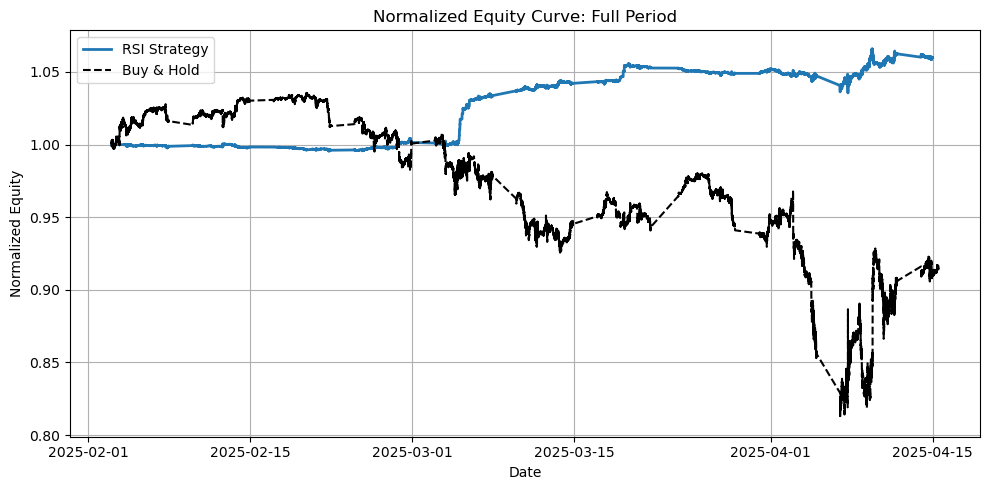

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data — make sure the file is in the same folder as your notebook
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Prepare indicators
def prepare_indicators(df, rsi_period=14, ob=70, os=20, vol_win=80, vol_med_win=1440):
    df = df.copy()
    returns = df['close'].pct_change()
    df['VOL_S'] = returns.rolling(vol_win).std()
    df['VOL_L'] = returns.rolling(vol_med_win).std()
    df['VOL_RATIO'] = df['VOL_S'] / df['VOL_L']

    tr1 = df['high'] - df['low']
    tr2 = (df['high'] - df['close'].shift()).abs()
    tr3 = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(14).mean()

    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(rsi_period).mean() / loss.rolling(rsi_period).mean()
    df['RSI'] = 100 - 100 / (1 + rs)

    df['Signal'] = np.select([df['RSI'] < os, df['RSI'] > ob], [1, -1], 0)
    return df

# Run RSI strategy and return normalized equity
def run_strategy(df, start, end):
    df = df.copy()
    cash, pos = 1_000_000, 0
    stop = target = entry_price = None
    equity = []
    dates = []

    for i in range(1, len(df)):
        date = df.index[i]
        price = df['close'].iloc[i]
        atr = df['ATR'].iloc[i]
        sig = df['Signal'].iloc[i]
        vol_ratio = df['VOL_RATIO'].iloc[i]

        if date < pd.to_datetime(start):
            continue
        if date > pd.to_datetime(end):
            break

        if pos > 0 and (price >= target or price <= stop):
            cash += pos * price
            pos = 0
        elif pos < 0 and (price <= target or price >= stop):
            cash -= -pos * price
            pos = 0

        if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
            if vol_ratio > 1.1 or vol_ratio < 0.9:
                qty = int((cash * 0.20) / price)
                qty = min(qty, 500)
                entry_price = price

                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - 2.0 * atr
                    target = price + 3.0 * atr
                elif sig == -1:
                    cash += qty * price
                    pos = -qty
                    stop = price + 2.0 * atr
                    target = price - 3.0 * atr

        portfolio = cash if pos == 0 else cash + pos * price
        equity.append(portfolio)
        dates.append(date)

    equity = np.array(equity) / equity[0]  # normalize to 1
    return pd.Series(equity, index=dates)

# Buy & Hold (normalized)
def buy_and_hold(df, start, end):
    sub = df.loc[start:end]
    return sub['close'] / sub['close'].iloc[0]

# Plot RSI vs B&H
def plot_equity_comparison(df, start, end, title):
    df = prepare_indicators(df)
    rsi_curve = run_strategy(df, start, end)
    bh_curve = buy_and_hold(df, start, end)

    plt.figure(figsize=(10, 5))
    plt.plot(rsi_curve.index, rsi_curve.values, label="RSI Strategy", linewidth=2)
    plt.plot(bh_curve.index, bh_curve.values, label="Buy & Hold", linestyle="--", color="black")
    plt.title(f"Normalized Equity Curve: {title}")
    plt.ylabel("Normalized Equity")
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot all three periods
plot_equity_comparison(df, "2025-02-03", "2025-02-18", "03 Feb – 18 Feb")
plot_equity_comparison(df, "2025-03-31", "2025-04-15", "31 Mar – 15 Apr")
plot_equity_comparison(df, "2025-02-03", "2025-04-15", "Full Period")


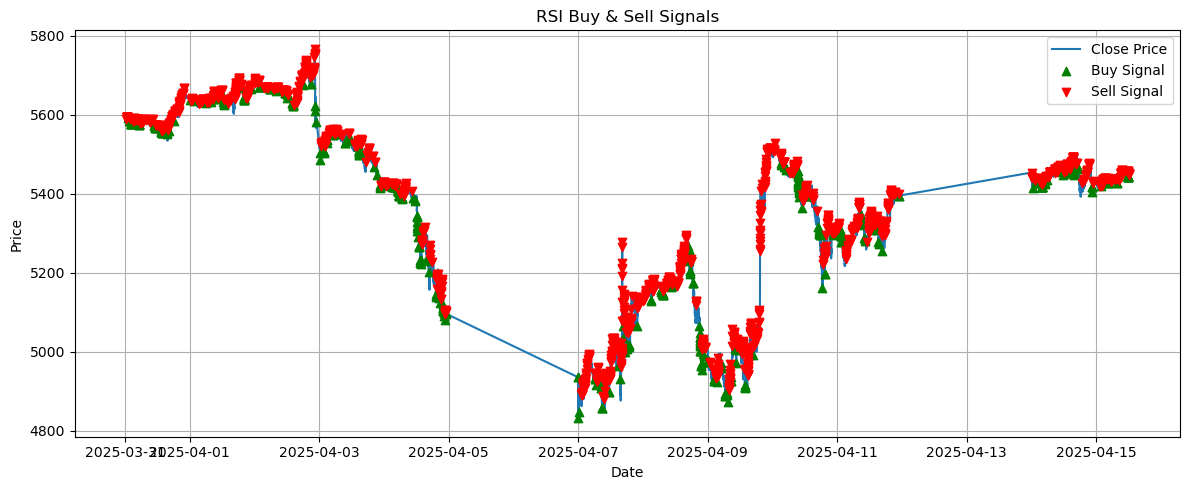

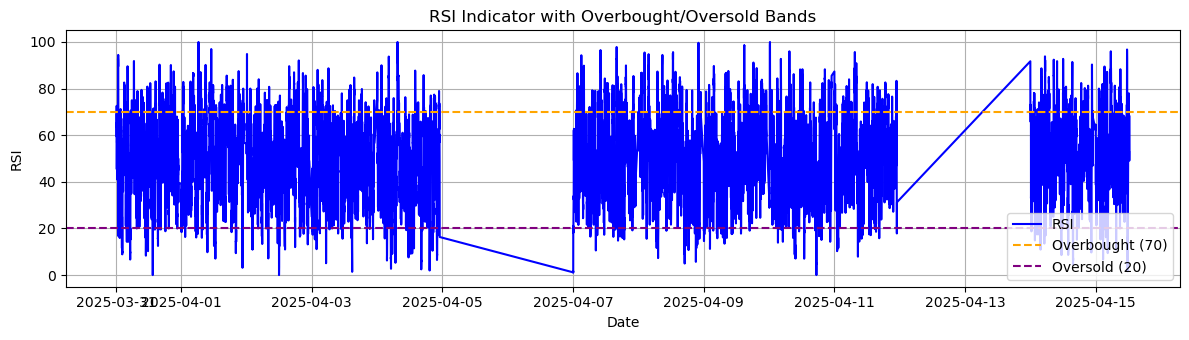

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your full dataset
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Define RSI parameters
RSI_PERIOD = 14
OB = 70
OS = 20

# Choose time range to visualize
start = "2025-03-31"
end = "2025-04-15"
df = df.loc[start:end].copy()

# Calculate RSI
delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(RSI_PERIOD).mean()
avg_loss = loss.rolling(RSI_PERIOD).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - 100 / (1 + rs)

# Generate RSI signals
df['Signal'] = np.select(
    [df['RSI'] < OS, df['RSI'] > OB],
    [1, -1], 0
)

# Extract buy/sell points
df['Buy'] = np.where(df['Signal'] == 1, df['close'], np.nan)
df['Sell'] = np.where(df['Signal'] == -1, df['close'], np.nan)

# --- Plot 1: Price with Buy/Sell signals
plt.figure(figsize=(12, 5))
plt.plot(df['close'], label='Close Price', linewidth=1.5)
plt.scatter(df.index, df['Buy'], marker='^', color='green', label='Buy Signal', zorder=3)
plt.scatter(df.index, df['Sell'], marker='v', color='red', label='Sell Signal', zorder=3)
plt.title("RSI Buy & Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: RSI + Bands
plt.figure(figsize=(12, 3.5))
plt.plot(df['RSI'], label='RSI', color='blue', linewidth=1.5)
plt.axhline(y=OB, color='orange', linestyle='--', label='Overbought (70)')
plt.axhline(y=OS, color='purple', linestyle='--', label='Oversold (20)')
plt.title("RSI Indicator with Overbought/Oversold Bands")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


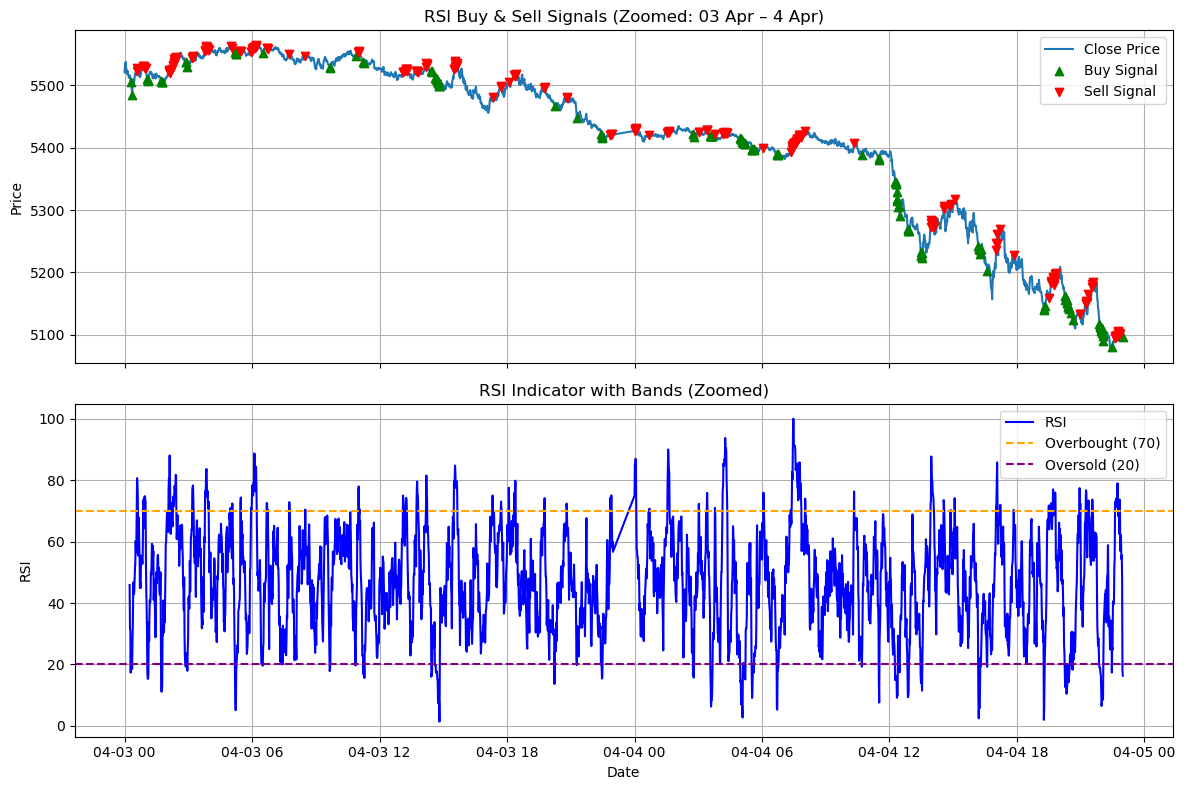

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset (adjust path if needed)
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Parameters
RSI_PERIOD = 14
OB = 70
OS = 20
start = "2025-04-3"
end = "2025-04-4"

# Slice and calculate RSI
df = df.loc[start:end].copy()
delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(RSI_PERIOD).mean()
avg_loss = loss.rolling(RSI_PERIOD).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - 100 / (1 + rs)

# Generate signals
df['Signal'] = np.select([df['RSI'] < OS, df['RSI'] > OB], [1, -1], 0)
df['Buy'] = np.where(df['Signal'] == 1, df['close'], np.nan)
df['Sell'] = np.where(df['Signal'] == -1, df['close'], np.nan)

# Plot price with buy/sell signals
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Price Plot ---
axs[0].plot(df['close'], label='Close Price', linewidth=1.5)
axs[0].scatter(df.index, df['Buy'], marker='^', color='green', label='Buy Signal', zorder=3)
axs[0].scatter(df.index, df['Sell'], marker='v', color='red', label='Sell Signal', zorder=3)
axs[0].set_title("RSI Buy & Sell Signals (Zoomed: 03 Apr – 4 Apr)")
axs[0].set_ylabel("Price")
axs[0].legend()
axs[0].grid(True)

# --- RSI Plot ---
axs[1].plot(df['RSI'], label='RSI', color='blue', linewidth=1.5)
axs[1].axhline(y=OB, color='orange', linestyle='--', label='Overbought (70)')
axs[1].axhline(y=OS, color='purple', linestyle='--', label='Oversold (20)')
axs[1].set_title("RSI Indicator with Bands (Zoomed)")
axs[1].set_ylabel("RSI")
axs[1].set_xlabel("Date")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Constants
TRADING_MINUTES_PER_DAY = 390
RSI_PERIOD = 14
RSI_OB = 70
RSI_OS = 20
K, D, OB, OS = 14, 7, 70, 10  # Stochastic parameters

# Compute returns
df['returns'] = df['close'].pct_change()

# Compute RSI
delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
rs = gain.rolling(RSI_PERIOD).mean() / loss.rolling(RSI_PERIOD).mean()
df['RSI'] = 100 - 100 / (1 + rs)
df['Signal_RSI'] = np.select([df['RSI'] < RSI_OS, df['RSI'] > RSI_OB], [1, -1], 0)

# Compute Stochastic Oscillator
df['%K'] = 100 * (df['close'] - df['low'].rolling(K).min()) / (df['high'].rolling(K).max() - df['low'].rolling(K).min())
df['%D'] = df['%K'].rolling(D).mean()
df['Signal_Stoch'] = 0
df.loc[(df['%K'].shift(1) < df['%D'].shift(1)) & (df['%K'] > df['%D']) & (df['%K'] < OS), 'Signal_Stoch'] = 1
df.loc[(df['%K'].shift(1) > df['%D'].shift(1)) & (df['%K'] < df['%D']) & (df['%K'] > OB), 'Signal_Stoch'] = -1

# Define periods
periods = {
    "03 Feb – 18 Feb": ("2025-02-03", "2025-02-18"),
    "31 Mar – 15 Apr": ("2025-03-31", "2025-04-15"),
}

# Function to compute Sharpe ratio
def compute_sharpe(df_sub, signal_col):
    df_sub = df_sub.copy()
    df_sub['strategy_returns'] = df_sub['returns'] * df_sub[signal_col].shift(1)
    mean = df_sub['strategy_returns'].mean()
    std = df_sub['strategy_returns'].std()
    sharpe = (mean / std) * np.sqrt(TRADING_MINUTES_PER_DAY) if std != 0 else np.nan
    return round(sharpe, 4)

# Evaluate for each strategy and period
sharpe_rsi, sharpe_stoch = {}, {}

for label, (start, end) in periods.items():
    df_sub = df.loc[start:end]
    sharpe_rsi[label] = compute_sharpe(df_sub, 'Signal_RSI')
    sharpe_stoch[label] = compute_sharpe(df_sub, 'Signal_Stoch')

# Display results
print("Sharpe Ratios (RSI):")
for k, v in sharpe_rsi.items():
    print(f"  {k}: {v}")

print("\nSharpe Ratios (Stochastic):")
for k, v in sharpe_stoch.items():
    print(f"  {k}: {v}")


Sharpe Ratios (RSI):
  03 Feb – 18 Feb: 0.0868
  31 Mar – 15 Apr: 0.0429

Sharpe Ratios (Stochastic):
  03 Feb – 18 Feb: -0.1991
  31 Mar – 15 Apr: 0.2312


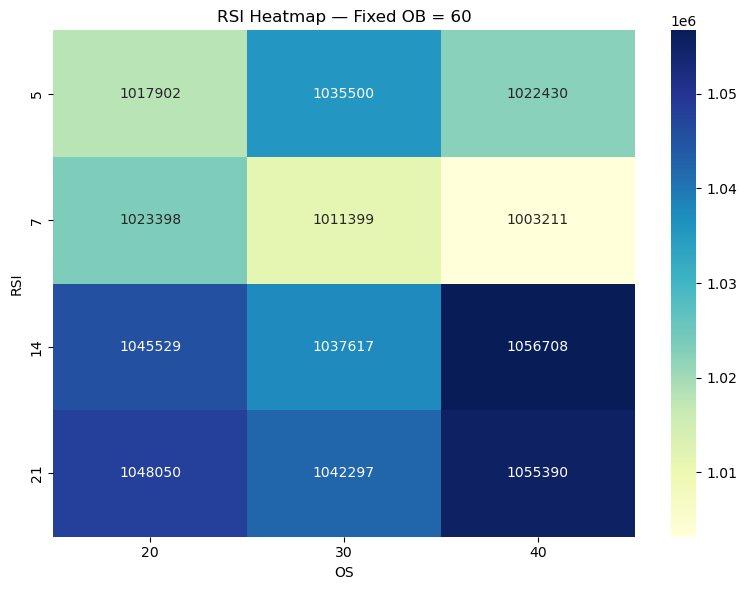

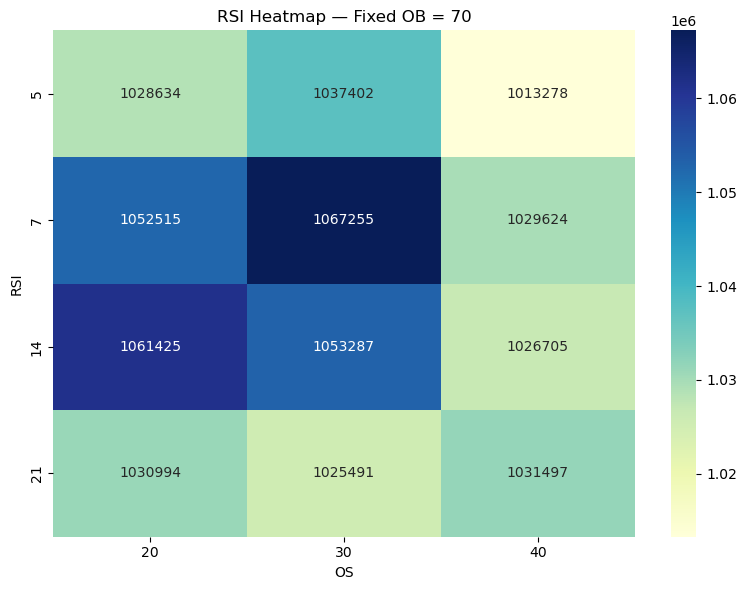

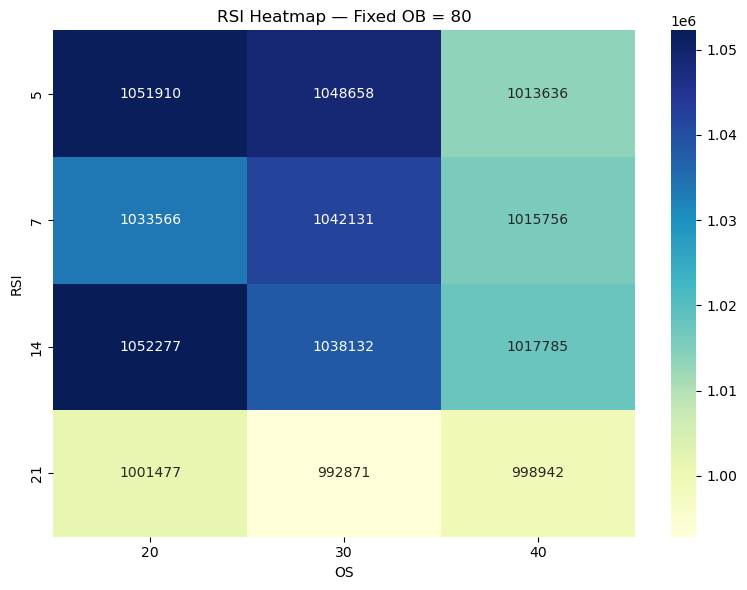

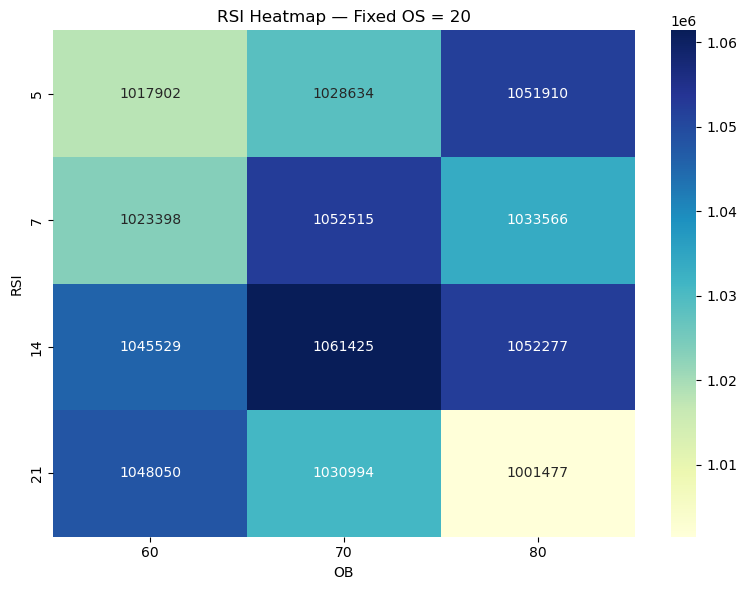

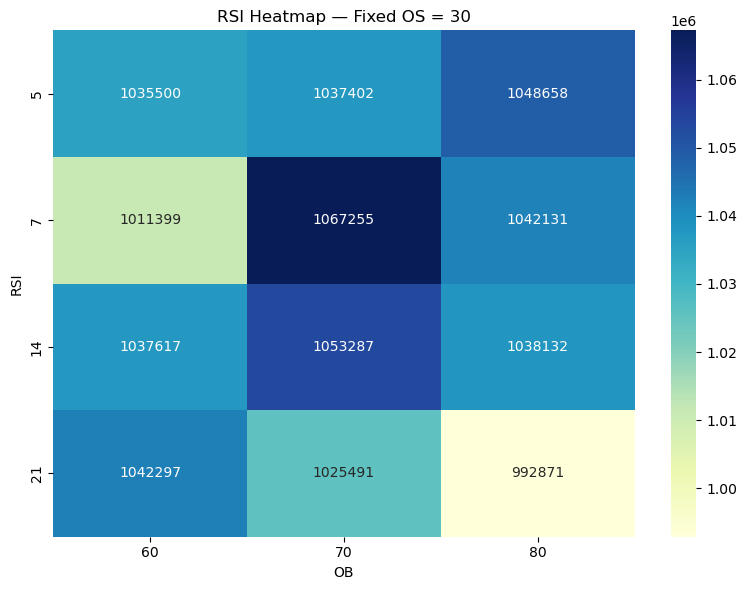

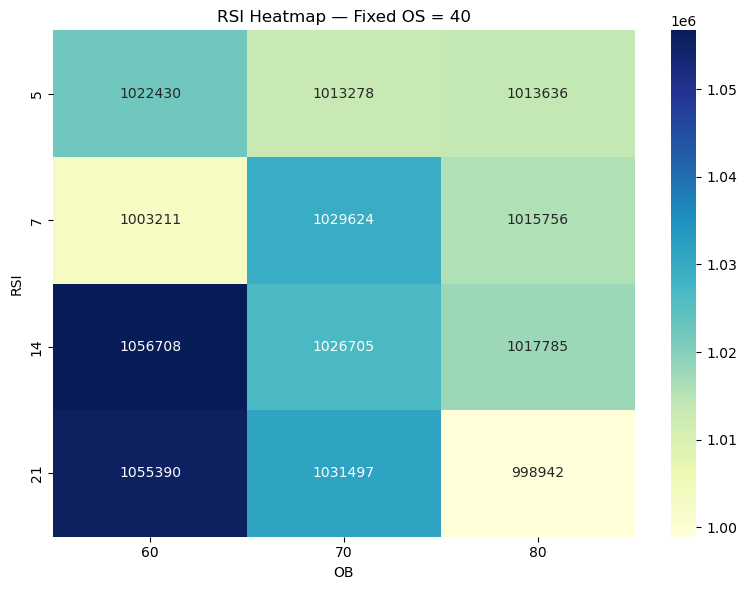

,RSI,OB,OS,Final,Trades,Win Rate (%),Swing %,Momentum %
13,7,70,30,1067255.0,2699,42.1,69.7,30.3
21,14,70,20,1061425.0,1876,43.3,70.5,29.5
20,14,60,40,1056707.8,2671,42.5,69.4,30.6
29,21,60,40,1055389.8,2660,42.7,70.4,29.6
22,14,70,30,1053286.8,2432,41.6,70.6,29.4
12,7,70,20,1052515.2,2543,42.1,68.9,31.1
24,14,80,20,1052276.8,1252,43.7,70.0,30.0
6,5,80,20,1051909.5,2510,43.2,68.9,31.1
7,5,80,30,1048657.5,2581,42.8,69.5,30.5
27,21,60,20,1048049.5,1705,43.2,68.7,31.3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Load and Prepare Data ──────────────────────────────────────
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Constants
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY, FEE = 500, 0

# RSI parameter grids
rsi_periods = [5, 7, 14, 21]
overbought_list = [60, 70, 80]
oversold_list = [20, 30, 40]

# Volatility regime (based on returns)
returns = df['close'].pct_change()
df['VOL_S'] = returns.rolling(VOL_WIN).std()
df['VOL_L'] = returns.rolling(VOL_MED_WIN).std()
df['VOL_RATIO'] = df['VOL_S'] / df['VOL_L']

# Average True Range (ATR)
tr1 = df['high'] - df['low']
tr2 = (df['high'] - df['close'].shift()).abs()
tr3 = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df['ATR'] = tr.rolling(14).mean()

# ─── RSI Strategy Evaluation ─────────────────────────────────────
results = []

for rsi_p in rsi_periods:
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(rsi_p).mean() / loss.rolling(rsi_p).mean()
    df['RSI'] = 100 - 100 / (1 + rs)

    for ob in overbought_list:
        for os in oversold_list:
            df['Signal'] = np.select(
                [df['RSI'] < os, df['RSI'] > ob],
                [1, -1], 0
            )

            cash, pos = CASH0, 0
            stop = target = entry_price = None
            equity = []
            num_trades = 0
            wins = 0
            swing_trades = 0
            momentum_trades = 0

            for i in range(1, len(df)):
                price = df['close'].iloc[i]
                atr = df['ATR'].iloc[i]
                sig = df['Signal'].iloc[i]
                vol_ratio = df['VOL_RATIO'].iloc[i]

                # Exit logic
                if pos > 0 and (price >= target or price <= stop):
                    cash += pos * price
                    pnl = price - entry_price
                    wins += 1 if pnl > 0 else 0
                    pos = 0
                elif pos < 0 and (price <= target or price >= stop):
                    cash -= -pos * price
                    pnl = entry_price - price
                    wins += 1 if pnl > 0 else 0
                    pos = 0

                # Entry logic
                if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
                    if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                        qty = int((cash * RISK_PCT) / price)
                        qty = min(qty, MAX_QTY)
                        entry_price = price

                        if sig == 1:
                            cash -= qty * price
                            pos = qty
                            stop = price - 2.0 * atr
                            target = price + 3.0 * atr
                        elif sig == -1:
                            cash += qty * price
                            pos = -qty
                            stop = price + 2.0 * atr
                            target = price - 3.0 * atr

                        # Regime classification of trade
                        if vol_ratio > THR_HIGH:
                            momentum_trades += 1
                        elif vol_ratio < THR_LOW:
                            swing_trades += 1

                        num_trades += 1

                equity.append(cash if pos == 0 else cash + pos * price)

            if equity:
                results.append({
                    'RSI': rsi_p,
                    'OB': ob,
                    'OS': os,
                    'Final': equity[-1],
                    'Trades': num_trades,
                    'Wins': wins,
                    'Swing': swing_trades,
                    'Momentum': momentum_trades
                })

# ─── Results Summary ─────────────────────────────────────────────
df_res = pd.DataFrame(results)
df_res['Win Rate (%)'] = (df_res['Wins'] / df_res['Trades']) * 100
df_res['Swing %'] = (df_res['Swing'] / df_res['Trades']) * 100
df_res['Momentum %'] = (df_res['Momentum'] / df_res['Trades']) * 100

# ─── Heatmaps ────────────────────────────────────────────────────
for fixed in ['OB', 'OS']:
    for val in sorted(df_res[fixed].unique()):
        pivot = df_res[df_res[fixed] == val].pivot(
            index='RSI',
            columns='OB' if fixed == 'OS' else 'OS',
            values='Final'
        )
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
        plt.title(f"RSI Heatmap — Fixed {fixed} = {val}")
        plt.xlabel('OB' if fixed == 'OS' else 'OS')
        plt.ylabel('RSI')
        plt.tight_layout()
        plt.show()

# ─── Top 10 Configurations with Extra Metrics ───────────────────
from IPython.display import display

top10 = df_res.sort_values(by='Final', ascending=False).head(10)
display(top10[['RSI', 'OB', 'OS', 'Final', 'Trades', 'Win Rate (%)', 'Swing %', 'Momentum %']].round(1))
